In [1]:
# basic dependencies

import numpy as np
from numpy import loadtxt
from numpy import savetxt

import pandas as pd
import math
import time
from datetime import date
from pathlib import Path
import os

np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})

###########

# torch dependencies
import torch

tkwargs = {"dtype": torch.double, # set as double to minimize zero error for cholesky decomposition error
           #"device": torch.device("cuda:0" if torch.cuda.is_available() else "cpu")} # set tensors to GPU, if multiple GPUs please set cuda:x properly
           "device": torch.device("cpu")}

torch.set_printoptions(precision=3)

###########

# botorch dependencies
import botorch

# data related
from botorch.utils.sampling import draw_sobol_samples
from botorch.utils.transforms import unnormalize, normalize

# surrogate model specific
from botorch.models.gp_regression import SingleTaskGP, FixedNoiseGP
from botorch.models.model_list_gp_regression import ModelListGP
from botorch.models.transforms.outcome import Standardize
from gpytorch.mlls.sum_marginal_log_likelihood import SumMarginalLogLikelihood
from gpytorch.mlls import ExactMarginalLogLikelihood

from botorch import fit_gpytorch_model

# qNEHVI specific
from botorch.acquisition.multi_objective.objective import IdentityMCMultiOutputObjective
from botorch.acquisition.multi_objective.monte_carlo import qNoisyExpectedHypervolumeImprovement

# utilities
from botorch.optim.optimize import optimize_acqf, optimize_acqf_list
from botorch.sampling.samplers import SobolQMCNormalSampler
from botorch.utils.multi_objective.pareto import is_non_dominated
from botorch.utils.multi_objective.hypervolume import Hypervolume
from typing import Optional
from torch import Tensor
from botorch.exceptions import BadInitialCandidatesWarning


from gpytorch.constraints import GreaterThan
from torch.optim import SGD


import warnings

warnings.filterwarnings('ignore', category=BadInitialCandidatesWarning)
warnings.filterwarnings('ignore', category=RuntimeWarning)

###########

# pymoo dependencies
import pymoo

from pymoo.factory import get_problem
from pymoo.core.problem import ElementwiseProblem

from pymoo.algorithms.moo.nsga3 import NSGA3
from pymoo.algorithms.moo.unsga3 import UNSGA3
from pymoo.util.ref_dirs import get_reference_directions
from pymoo.optimize import minimize
from pymoo.core.termination import NoTermination

from pymoo.core.problem import Problem

###########

from sklearn.preprocessing import MinMaxScaler
from scipy.stats import qmc
from scipy.stats import gaussian_kde # for density plot

###########

# plotting dependencies
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

# this is for the colorbar, you can change the cmap if you prefer other colour schemes
from matplotlib.cm import ScalarMappable
cm = plt.cm.get_cmap('viridis')

# function to return the std dev across runs
def ci(y, N_TRIALS):
    return 1.96 * y.std(axis=0) / np.sqrt(N_TRIALS)

SMALL_SIZE = 14
MEDIUM_SIZE = 18
BIGGER_SIZE = 20

plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [2]:
def optimize_qnehvi(problem, ref_point, initial_x, # must haves
                    N_BATCH, BATCH_SIZE, 
                    random_state=torch.randint(1000000, (1,)).item(), noise=0, verbose=False): # change noise here!
    
    print("Optimizing with Pure qNEHVI")

    t0 = time.time()

    # some initializing 
    torch.manual_seed(random_state) # gives a consistent seed based on the trial number
    hv=Hypervolume(ref_point=ref_point) # sets the hv based on problem, flip since BoTorch takes maximisation
    hvs = [] # create a blank array to append the scores at each batch/iteration for that run
    
    ##########
    # generate initial training data for that run
    train_x = initial_x
    train_obj, train_con = problem.evaluate(train_x)

    # add noise, by default noise=0, so train_noisy = train, noise factor determines amt of std dev to add
    train_obj_noisy = train_obj + noise*torch.randn_like(train_obj)
    train_con_noisy = train_con + noise*torch.randn_like(train_con)
    
    ##########
    
    # normalize inputs to [0,1] first before feeding into model
    standard_bounds = torch.zeros(2, problem.n_var, **tkwargs)
    standard_bounds[1] = 1
    train_x_gp = normalize(train_x, problem.bounds)
    
    # form the output train_y data by concentenating ground truth train_obj with its feasibility value on the rightmost
    # this is necessary since the surrogate GpyTorch model needs to model BOTH obj and con for predicted candidates
    train_y = torch.cat([train_obj_noisy, train_con_noisy], dim=-1) # model takes noisy observations

    # define and train surrogate models for objective and constraint
    models = []
    for i in range(train_y.shape[-1]):
        models.append(SingleTaskGP(train_x_gp, train_y[..., i : i + 1], outcome_transform=Standardize(m=1)))
    model = ModelListGP(*models)
    mll = SumMarginalLogLikelihood(model.likelihood, model)
        
    ##########    
    
    def create_idxr(i):
        def idxr(Z):
            return Z[..., i]

        return idxr

    def create_idxrs():
        return [create_idxr(i=i) for i in range(problem.n_obj, problem.n_obj+problem.n_constr)]
    
    # original location for an extra HV check wrt to initial samples
    
    ########## ########## ########## start of iteration loop


    # training loop for N_BATCH iterations
    for iteration in range(1, N_BATCH + 1):    

        t3 = time.time()
                
        # fit the surrogate model
        fit_gpytorch_model(mll)    
                
        ##########
            
        # define the acqusition function for EIC if feas_weighting is false
        acq_func = qNoisyExpectedHypervolumeImprovement(
            model=model,
            ref_point=ref_point, # for computing HV, must flip for BoTorch
            X_baseline=train_x_gp, # feed total list of train_x for this current iteration
            sampler=SobolQMCNormalSampler(num_samples=128),  # determines how candidates are randomly proposed before selection
            objective=IdentityMCMultiOutputObjective(outcomes=np.arange(problem.n_obj).tolist()), # optimize first n_obj col 
            constraints=create_idxrs(), # constraint on last n_constr col
            prune_baseline=True, cache_pending=True)  # options for improving qNEHVI, keep these on
        
        ##########
        
        # propose candidates given defined qNEHVI acq func given model and latest observed training data
        new_x, _ = optimize_acqf(
                        acq_function=acq_func,
                        bounds=standard_bounds, # since train_x was normalized
                        q=BATCH_SIZE, # no of candidates to propose in parallel
                        num_restarts=2, # no of restarts of raw_samples
                        raw_samples=256,  # pool of samples to choose the starting points from
                        options={"batch_limit": 5, "maxiter": 200}, # default arguments, not too sure about this yet
                        )

        # unormalize our training inputs back to original problem bounds
        new_x =  unnormalize(new_x.detach(), bounds=problem.bounds)
        
        # repair new_x
        for i in range(new_x.shape[0]):
            if 0.3 - new_x[i,1]/new_x[i,4] > 0:
                new_x[i,4] = min(new_x[i,1]/0.3, new_x[i,4])

        for i in range(new_x.shape[0]):
            if 2 - (new_x[i,1]/new_x[i,4]) - (new_x[i,3]/new_x[i,1]) > 0:
                new_x[i,3] = max((2-new_x[i,1]/new_x[i,4])*new_x[i,1], new_x[i,3])
                
        # feed new proposed observations into objective func to get its new ground truth
        new_obj, new_con = problem.evaluate(new_x)

        # add noise, by default noise=0, so train_noisy = train, noise factor determines amt of std dev to add
        new_obj_noisy = new_obj + noise*torch.randn_like(new_obj)
        new_con_noisy = new_con + noise*torch.randn_like(new_con)

        # update training points by concatenating the new values into their respective tensors
        train_x = torch.cat([train_x, new_x])
        train_obj = torch.cat([train_obj, new_obj])
        train_con = torch.cat([train_con, new_con])
        train_obj_noisy = torch.cat([train_obj_noisy, new_obj_noisy])
        train_con_noisy = torch.cat([train_con_noisy, new_con_noisy])
        
        ##########
        
        # computing HV of current candidate list
        is_feas = (train_con <= 0).all(dim=-1) # check whether points fit ALL (.all) constraint criteria
        feas_train_obj = train_obj[is_feas] # take only points that fit the 1st check
        if feas_train_obj.shape[0] > 0:
            pareto_mask = is_non_dominated(feas_train_obj) # check for 2nd criteria: non-dominated, meaning new pareto optimal
            pareto_y = feas_train_obj[pareto_mask] # take only points that fit the 2nd check
            volume = hv.compute(pareto_y) # compute change in HV with new pareto optimal wrt to original ref point
        else:
            volume = 0.0
        
        hvs.append(volume)
        
        ##########

        # update the surrogate models for next iteration
        train_x_gp = normalize(train_x, problem.bounds) # dont forget to renormalize!
        train_y = torch.cat([train_obj_noisy, train_con_noisy], dim=-1) # model takes noisy observations

        models = []
        for i in range(train_y.shape[-1]):
            models.append(SingleTaskGP(train_x_gp, train_y[..., i : i + 1], outcome_transform=Standardize(m=1)))
        model = ModelListGP(*models)
        mll = SumMarginalLogLikelihood(model.likelihood, model)
        
        ##########
        
        t4 = time.time()
        if verbose:
            print(
                    f"Batch {iteration:>2} of {N_BATCH}: Hypervolume = "
                    f"{hvs[-1]:>4.2f}, "
                    f"time = {t4-t3:>4.2f}s.\n"
                    , end="")
            
        del new_x, new_obj, new_con, new_obj_noisy, new_con_noisy, train_y
        torch.cuda.empty_cache() # clear some memory here between each run/trial     
        
        ########## ########## ########## end of iteration loop

    t1 = time.time()
    print(f"Time taken in total: {t1-t0:>4.2f}s.")       
    
    # returns the HV score across iterations, total training set as an array
    return hvs, torch.hstack([train_x, train_obj, train_con]).cpu().numpy()

In [3]:
def optimize_hybrid_nsga(problem, ref_point, initial_x, # must haves
                         N_BATCH, BATCH_SIZE, 
                         random_state=torch.randint(1000000, (1,)).item(), noise=0, verbose=False): # change noise here!
    
    print("Optimizing with Hybrid qNEHVI + U-NSGA-III")

    t0 = time.time()

    torch.manual_seed(random_state) # gives a consistent seed based on the trial number
    hv=Hypervolume(ref_point=ref_point) # sets the hv based on problem, flip since BoTorch takes maximisation
    hvs = [] # create a blank array to append the scores at each batch/iteration for that run
    
    pymooproblem = Problem(n_var=problem.n_var, n_obj=problem.n_obj, n_constr=problem.n_constr, 
                  xl=np.zeros(problem.n_var), xu=np.ones(problem.n_var))

    ##########
    # generate initial training data for that run
    train_x = initial_x
    train_obj, train_con = problem.evaluate(train_x)

    # add noise, by default noise=0, so train_noisy = train, noise factor determines amt of std dev to add
    train_obj_noisy = train_obj + noise*torch.randn_like(train_obj)
    train_con_noisy = train_con + noise*torch.randn_like(train_con)

    ##########

    # normalize inputs to [0,1] first before feeding into model
    standard_bounds = torch.zeros(2, problem.n_var, **tkwargs)
    standard_bounds[1] = 1
    train_x_gp = normalize(train_x, problem.bounds)

    # form the output train_y data by concentenating ground truth train_obj with its feasibility value on the rightmost
    # this is necessary since the surrogate GpyTorch model needs to model BOTH obj and con for predicted candidates
    train_y = torch.cat([train_obj_noisy, train_con_noisy], dim=-1) # model takes noisy observations

    # define and train surrogate models for objective and constraint
    models = []
    for i in range(train_y.shape[-1]):
        models.append(SingleTaskGP(train_x_gp, train_y[..., i : i + 1], outcome_transform=Standardize(m=1)))
    model = ModelListGP(*models)
    mll = SumMarginalLogLikelihood(model.likelihood, model)
    
    ##########    
    
    def create_idxr(i):
        def idxr(Z):
            return Z[..., i]

        return idxr

    def create_idxrs():
        return [create_idxr(i=i) for i in range(problem.n_obj, problem.n_obj+problem.n_constr)]
    
    ########## ########## ########## start of iteration loop

    for iteration in range(1, N_BATCH + 1):   

        t3 = time.time()

        ##########

        fit_gpytorch_model(mll)  

        # define the acqusition function for EIC if feas_weighting is false
        acq_func = qNoisyExpectedHypervolumeImprovement(
            model=model,
            ref_point=ref_point, # for computing HV, must flip for BoTorch
            X_baseline=train_x_gp, # feed total list of train_x for this current iteration
            sampler=SobolQMCNormalSampler(num_samples=128),  # determines how candidates are randomly proposed before selection
            objective=IdentityMCMultiOutputObjective(outcomes=np.arange(problem.n_obj).tolist()), # optimize first n_obj col 
            constraints=create_idxrs(), # constraint on last n_constr col
            prune_baseline=True, cache_pending=True)  # options for improving qNEHVI, keep these on

        # propose best candidates given QMC and qNEHVI
        qnehvi_x, _ = optimize_acqf(acq_function=acq_func,
                                    bounds=standard_bounds, # since train_x was normalized
                                    q=BATCH_SIZE, # no of candidates to propose in parallel, 12 is the max for a GTX1065
                                    num_restarts=1, # no of restarts if q candidates fail to show improvement
                                    raw_samples=256,  # pool of samples to choose the starting points from
                                    options={"batch_limit": 5, "maxiter": 200}, # default arguments, not too sure about this yet
                                 )

        ##########

        # we pick out the best points so far to form parents
        pareto_mask = is_non_dominated(train_obj_noisy)
        pareto_y = -train_obj_noisy[pareto_mask]
        pareto_x = train_x_gp[pareto_mask]
        pareto_con = train_con_noisy[pareto_mask]
        
        algorithm = UNSGA3(pop_size=256,
                           ref_dirs=get_reference_directions("energy", problem.n_obj, BATCH_SIZE, seed=random_state),
                           sampling=pareto_x.cpu().numpy(),
                          )

        algorithm.setup(pymooproblem, termination=NoTermination())

        # set the 1st population to the current evaluated population
        pop = algorithm.ask()
        pop.set("F", pareto_y.cpu().numpy())
        pop.set("G", pareto_con.cpu().numpy())
        algorithm.tell(infills=pop)

        # propose children based on tournament selection -> crossover/mutation
        newpop = algorithm.ask()
        nsga3_x = torch.tensor(newpop.get("X"), **tkwargs)
        
        ##########

        candidates = torch.cat([qnehvi_x, nsga3_x])

        acq_value_list = []

        for i in range(0, candidates.shape[0]):
            with torch.no_grad():
                acq_value = acq_func(candidates[i].unsqueeze(dim=0))
                acq_value_list.append(acq_value.item())

        sorted_x = candidates.cpu().numpy()[np.argsort(acq_value_list)]

        ##########
        
        new_x = torch.tensor(sorted_x[-BATCH_SIZE:], **tkwargs) # take best BATCH_SIZE samples
        new_x =  unnormalize(new_x.detach(), bounds=problem.bounds)
        
        # repair new_x
        for i in range(new_x.shape[0]):
            if 0.3 - new_x[i,1]/new_x[i,4] > 0:
                new_x[i,4] = min(new_x[i,1]/0.3, new_x[i,4])

        for i in range(new_x.shape[0]):
            if 2 - (new_x[i,1]/new_x[i,4]) - (new_x[i,3]/new_x[i,1]) > 0:
                new_x[i,3] = max((2-new_x[i,1]/new_x[i,4])*new_x[i,1], new_x[i,3])
                
        new_obj, new_con = problem.evaluate(new_x)

        # add noise, by default noise=0, so train_noisy = train, noise factor determines amt of std dev to add
        new_obj_noisy = new_obj + noise*torch.randn_like(new_obj)
        new_con_noisy = new_con + noise*torch.randn_like(new_con)

        # update training points by concatenating the new values into their respective tensors
        train_x = torch.cat([train_x, new_x])
        train_obj = torch.cat([train_obj, new_obj])
        train_con = torch.cat([train_con, new_con])
        train_obj_noisy = torch.cat([train_obj_noisy, new_obj_noisy])
        train_con_noisy = torch.cat([train_con_noisy, new_con_noisy])

        # computing HV of current candidate list
        is_feas = (train_con <= 0).all(dim=-1) # check whether points fit ALL (.all) constraint criteria
        feas_train_obj = train_obj[is_feas] # take only points that fit the 1st check
        if feas_train_obj.shape[0] > 0:
            pareto_mask = is_non_dominated(feas_train_obj) # check for 2nd criteria: non-dominated, meaning new pareto optimal
            pareto_y = feas_train_obj[pareto_mask] # take only points that fit the 2nd check
            volume = hv.compute(pareto_y) # compute change in HV with new pareto optimal wrt to original ref point
        else:
            volume = 0.0

        hvs.append(volume)

        ##########

        # update the surrogate models for next iteration
        train_x_gp = normalize(train_x, problem.bounds) # dont forget to renormalize!
        train_y = torch.cat([train_obj_noisy, train_con_noisy], dim=-1) # model takes noisy observations

        models = []
        for i in range(train_y.shape[-1]):
            models.append(SingleTaskGP(train_x_gp, train_y[..., i : i + 1], outcome_transform=Standardize(m=1)))
        model = ModelListGP(*models)
        mll = SumMarginalLogLikelihood(model.likelihood, model)

        ##########

        t4 = time.time()
        if verbose:
            print(
                    f"Batch {iteration:>2} of {N_BATCH}: Hypervolume = "
                    f"{hvs[-1]:>4.2f}, "
                    f"time = {t4-t3:>4.2f}s.\n"
                    , end="")

        del new_x, new_obj, new_con, qnehvi_x, nsga3_x, new_obj_noisy, new_con_noisy, train_y
        torch.cuda.empty_cache() # clear some memory here between each run/trial    
        
    t1 = time.time()
    print(f"Time taken in total: {t1-t0:>4.2f}s.")   
    
    del models, model, mll
    torch.cuda.empty_cache() # clear some memory here between each run/trial  
    
    # returns the HV score across iterations, total training set as an array
    return hvs, torch.hstack([train_x, train_obj, train_con]).cpu().numpy()

In [4]:
df = pd.read_csv('Results_Run15.csv')
df

,Cond,Qtsc,Qag,Qpva,Qseed,Qaa,y1,y2,y3,c1,c2
0,1,20.723363,12.953919,22.057069,18.571091,9.179962,0.601600,0.013235,0.226205,-1.111108,-8.447354e-01
1,2,11.441927,9.235287,7.446133,21.407840,18.947371,0.434961,0.017346,0.108007,-0.187418,-8.054659e-01
2,3,2.754681,11.048728,18.566012,3.432239,3.910927,0.367403,0.005619,0.856990,-2.525092,-1.135738e+00
3,4,1.449833,4.047471,12.575087,23.347719,10.787064,0.633723,0.011473,0.027178,-0.075215,-4.143686e+00
4,5,7.768571,7.631449,10.762707,11.340272,14.846944,0.342266,0.012207,0.527489,-0.214008,-9.167080e-10
...,...,...,...,...,...,...,...,...,...,...,...
67,68,1.468149,23.946571,20.069563,23.996267,23.996370,0.309824,0.050596,0.000156,-0.697925,0.000000e+00
68,69,1.312893,23.728265,0.676884,15.774632,17.771365,0.315712,0.033536,0.342724,-1.035197,0.000000e+00
69,70,0.600000,19.510866,16.252405,23.160320,24.000000,0.312812,0.038633,0.034987,-0.512953,-2.220446e-16
70,71,0.600000,23.882699,0.744571,14.982281,17.398691,0.333352,0.032074,0.375738,-1.072672,0.000000e+00


In [32]:
df_torch = torch.tensor(df[df.columns[1:]].values, **tkwargs) # excluding condition no
train_x = df_torch[...,0:5]
train_y = df_torch[...,5:7]

true_bounds = torch.tensor([[0.6,  0.6,  0.6,  0.6,  0.6], 
                       [24,  24,  24,  24,  24]], **tkwargs)
train_x = normalize(train_x, true_bounds)

In [ ]:
standard_bounds = torch.zeros(2, problem.n_var, **tkwargs)
standard_bounds[1] = 1

In [35]:
unnormalize(train_x, true_bounds)

tensor([[20.723, 12.954, 22.057, 18.571,  9.180],
        [11.442,  9.235,  7.446, 21.408, 18.947],
        [ 2.755, 11.049, 18.566,  3.432,  3.911],
        [ 1.450,  4.047, 12.575, 23.348, 10.787],
        [ 7.769,  7.631, 10.763, 11.340, 14.847],
        [16.995, 19.446,  1.909,  1.418,  4.700],
        [ 5.439, 22.900, 16.768, 11.885, 12.931],
        [13.626,  4.501,  9.907,  5.439,  1.675],
        [ 9.258, 17.783,  5.512, 15.917,  7.128],
        [23.729, 14.791,  3.536, 19.265, 21.206],
        [15.888, 20.662, 20.214, 22.340, 22.488],
        [19.595,  1.448, 15.552, 13.338,  4.827],
        [ 8.211, 20.598, 10.777,  2.614,  4.757],
        [18.630, 22.923,  1.909,  5.548, 13.039],
        [16.995, 22.832,  1.710,  4.568, 12.685],
        [20.229, 23.470, 18.064,  2.665, 11.710],
        [ 8.211, 20.598, 10.777, 12.335, 14.700],
        [ 6.848, 22.871,  9.856,  0.600,  0.600],
        [ 3.770, 23.938,  8.262, 20.266, 20.755],
        [19.132, 23.922, 22.201, 23.988, 23.988],


In [28]:
model1 = SingleTaskGP(train_X=train_x, train_Y=train_y[...,0].unsqueeze(1), outcome_transform=Standardize(m=1))
model1.likelihood.noise_covar.register_constraint("raw_noise", GreaterThan(1e-5))

mll = ExactMarginalLogLikelihood(likelihood=model1.likelihood, model=model1)
# set mll and all submodules to the specified dtype and device
mll = mll.to(train_x)

optimizer = SGD([{'params': model1.parameters()}], lr=0.1)

NUM_EPOCHS = 500

model1.train()

for epoch in range(NUM_EPOCHS):
    # clear gradients
    optimizer.zero_grad()
    # forward pass through the model to obtain the output MultivariateNormal
    output = model1(train_x)
    # Compute negative marginal log likelihood
    loss = - mll(output, model1.train_targets)
    # back prop gradients
    loss.backward()
    # print every 10 iterations
    if (epoch + 1) % 50 == 0:
        print(
            f"Epoch {epoch+1:>3}/{NUM_EPOCHS} - Loss: {loss.item():>4.3f} "
            #f"lengthscale: {model.covar_module.base_kernel.lengthscale} " 
            f"noise: {model1.likelihood.noise.item():>4.3f}" 
         )
    optimizer.step()

Epoch  50/500 - Loss: 1.554 noise: 1.571
Epoch 100/500 - Loss: 1.444 noise: 1.064
Epoch 150/500 - Loss: 1.344 noise: 0.693
Epoch 200/500 - Loss: 1.253 noise: 0.454
Epoch 250/500 - Loss: 1.148 noise: 0.287
Epoch 300/500 - Loss: 1.042 noise: 0.171
Epoch 350/500 - Loss: 0.964 noise: 0.105
Epoch 400/500 - Loss: 0.924 noise: 0.072
Epoch 450/500 - Loss: 0.908 noise: 0.058
Epoch 500/500 - Loss: 0.902 noise: 0.051


In [29]:
model2 = SingleTaskGP(train_X=train_x, train_Y=train_y[...,1].unsqueeze(1), outcome_transform=Standardize(m=1))
model2.likelihood.noise_covar.register_constraint("raw_noise", GreaterThan(1e-5))

mll = ExactMarginalLogLikelihood(likelihood=model2.likelihood, model=model2)
# set mll and all submodules to the specified dtype and device
mll = mll.to(train_x)

optimizer = SGD([{'params': model2.parameters()}], lr=0.1)

NUM_EPOCHS = 500

model2.train()

for epoch in range(NUM_EPOCHS):
    # clear gradients
    optimizer.zero_grad()
    # forward pass through the model to obtain the output MultivariateNormal
    output = model2(train_x)
    # Compute negative marginal log likelihood
    loss = - mll(output, model2.train_targets)
    # back prop gradients
    loss.backward()
    # print every 10 iterations
    if (epoch + 1) % 50 == 0:
        print(
            f"Epoch {epoch+1:>3}/{NUM_EPOCHS} - Loss: {loss.item():>4.3f} "
            #f"lengthscale: {model.covar_module.base_kernel.lengthscale} " 
            f"noise: {model2.likelihood.noise.item():>4.3f}" 
         )
    optimizer.step()

Epoch  50/500 - Loss: 1.359 noise: 1.338
Epoch 100/500 - Loss: 1.039 noise: 0.591
Epoch 150/500 - Loss: 0.668 noise: 0.191
Epoch 200/500 - Loss: 0.457 noise: 0.077
Epoch 250/500 - Loss: 0.401 noise: 0.050
Epoch 300/500 - Loss: 0.390 noise: 0.044
Epoch 350/500 - Loss: 0.387 noise: 0.043
Epoch 400/500 - Loss: 0.385 noise: 0.042
Epoch 450/500 - Loss: 0.385 noise: 0.042
Epoch 500/500 - Loss: 0.384 noise: 0.042


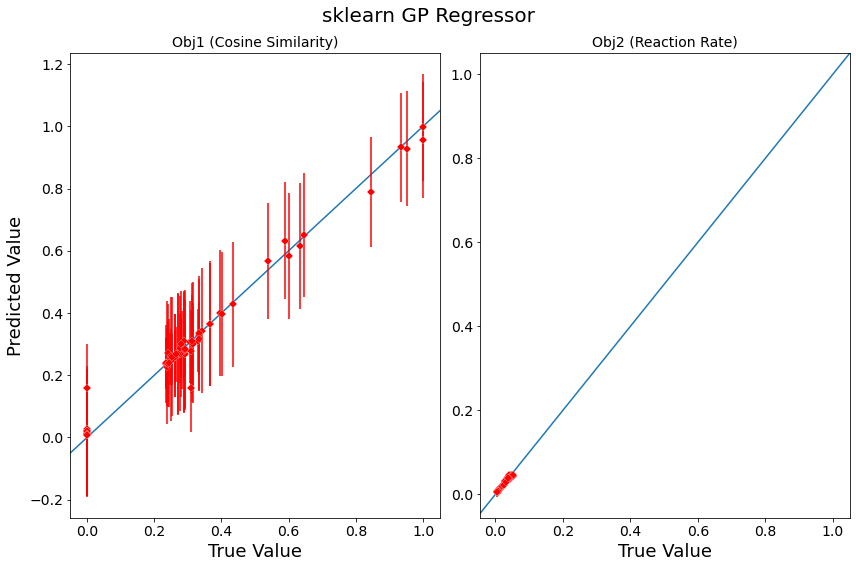

In [36]:
fig, ax = plt.subplots(ncols = 2, figsize = (12,8))

model1.eval()
model2.eval()

for i, model, obj in zip([0,1],
                        [model1, model2],
                        ["Obj1 (Cosine Similarity)", "Obj2 (Reaction Rate)"]):
    
    with torch.no_grad():
        y_true = train_y[...,i]
        posterior = model.posterior(train_x)  
        y_pred = posterior.mean.squeeze()
        lower, upper = posterior.mvn.confidence_region()
        yerr = upper-lower

        ax[i].axline((1, 1), slope=1)

        ax[i].errorbar(x=y_true.cpu().numpy(), y=y_pred.cpu().numpy(), yerr=yerr.cpu().numpy(), ls='', 
                        marker='D', mec='w', mew=0.2, mfc='r', c='r', 
                        #label='{:} R$^2$={:.3f}'.format(s,r2)
                       )

        ax[i].set_title(obj)
        ax[i].set_xlabel('True Value')
    
ax[0].set_ylabel('Predicted Value')
fig.suptitle('sklearn GP Regressor')
fig.tight_layout()

In [37]:
class Problem_AgNP(torch.nn.Module):
    
    name = 'AgNp'
    
    #must define these!
    n_var = 5
    n_obj = 3
    n_constr = 2
    
    ref_point = torch.tensor([0,0,0], **tkwargs)
        
    # input bounds, don't forget to change according to n_var!  
    bounds = torch.tensor([[0,  0,  0,  0,  0], [1,  1,  1,  1,  1]], **tkwargs)

    def evaluate(X):
    
        model1.eval()
        model2.eval()
    
        with torch.no_grad():

            y1 = model1.posterior(X).mean.squeeze(1)
            y2 = model2.posterior(X).mean.squeeze(1)
            y3 = 1-X[...,3]

            output = torch.stack([y1,y2,y3], dim=1).squeeze(1)

            X = unnormalize(X, bounds=true_bounds)
            c1 = 0.3 - X[...,1]/X[...,4]
            c2 = 2 - (X[...,1]/X[...,4]) - (X[...,3]/X[...,1])

            slack = torch.stack([c1,c2], dim=1).squeeze(1)
        
        return output, slack

In [38]:
problem = Problem_AgNP

N_TRIALS = 3
verbose = True
noise = 0.00

N_BATCH = 15
BATCH_SIZE = 4

ref_point1 = torch.tensor([0,0,0], **tkwargs)
ref_point2 = torch.tensor([0,0,0.5], **tkwargs)

hvs_qnehvi1, hvs_qnehvi2, hvs_hybrid1, hvs_hybrid2 = [], [], [], []
train_qnehvi1, train_qnehvi2, train_hybrid1, train_hybrid2 = [], [], [], []

# main loop for each trial/run, random_state will be trial number
for trial in range(1, N_TRIALS + 1):
    print(f"\nTrial {trial:>2} of {N_TRIALS} for problem {problem.name} with d = {problem.n_var}\n", end="")

    # initialize with a 2*(d+1) sample set

    initial_x = draw_sobol_samples(bounds=problem.bounds,n=1, q=12, seed=trial).squeeze(0)
    
    # repair inputs to feasibility
    for i in range(initial_x.shape[0]):
        if 0.3 - initial_x[i,1]/initial_x[i,4] > 0:
            initial_x[i,4] = min(initial_x[i,1]/0.3, initial_x[i,4])

    for i in range(initial_x.shape[0]):
        if 2 - (initial_x[i,1]/initial_x[i,4]) - (initial_x[i,3]/initial_x[i,1]) > 0:
            initial_x[i,3] = max((2-initial_x[i,1]/initial_x[i,4])*initial_x[i,1], initial_x[i,3])
                
    for algo, hv_list, train_list in zip(
        [optimize_qnehvi, optimize_hybrid_nsga],
        [hvs_qnehvi1, hvs_hybrid1],
        [train_qnehvi1, train_hybrid1],
    ):
    
    
        hv, train = algo(problem, ref_point1, initial_x,
                         N_BATCH=N_BATCH, BATCH_SIZE=BATCH_SIZE,
                         random_state=trial, noise=noise, verbose=verbose)
        hv_list.append(hv)
        train_list.append(train)
    
for algo_name, hv_list, train_list in zip(['qnehvi', 'hybrid',],
                                          [hvs_qnehvi1, hvs_hybrid1],
                                          [train_qnehvi1, train_hybrid1]
                                         ):
    
    savetxt(f"{problem.name}_hvs_{algo_name}_{N_BATCH}by{BATCH_SIZE}_{N_TRIALS}trials.csv", hv_list, delimiter=',')    
    savetxt(f"{problem.name}_train_{algo_name}_{N_BATCH}by{BATCH_SIZE}_{N_TRIALS}trials.csv", np.array(train_list).reshape(-1), delimiter=',')

print("ALL DONE!")


Trial  1 of 3 for problem AgNp with d = 5
Optimizing with Pure qNEHVI
Batch  1 of 15: Hypervolume = 0.00, time = 3.36s.
Batch  2 of 15: Hypervolume = 0.00, time = 11.05s.
Batch  3 of 15: Hypervolume = 0.00, time = 15.02s.
Batch  4 of 15: Hypervolume = 0.00, time = 35.76s.
Batch  5 of 15: Hypervolume = 0.00, time = 14.48s.
Batch  6 of 15: Hypervolume = 0.00, time = 25.06s.
Batch  7 of 15: Hypervolume = 0.00, time = 8.98s.
Batch  8 of 15: Hypervolume = 0.01, time = 37.59s.
Batch  9 of 15: Hypervolume = 0.01, time = 36.05s.
Batch 10 of 15: Hypervolume = 0.01, time = 44.67s.
Batch 11 of 15: Hypervolume = 0.01, time = 18.33s.
Batch 12 of 15: Hypervolume = 0.01, time = 34.44s.
Batch 13 of 15: Hypervolume = 0.01, time = 49.29s.
Batch 14 of 15: Hypervolume = 0.01, time = 32.81s.
Batch 15 of 15: Hypervolume = 0.01, time = 41.65s.
Time taken in total: 408.57s.
Optimizing with Hybrid qNEHVI + U-NSGA-III
Batch  1 of 15: Hypervolume = 0.00, time = 7.30s.
Batch  2 of 15: Hypervolume = 0.00, time = 

Exception: Population Set Attribute Error: Number of values and population size do not match!

In [ ]:
problem = Problem_AgNP

N_BATCH = 15
BATCH_SIZE = 4
N_TRIALS = 1

fig, ax = plt.subplots(1, 1, figsize=(7, 5))

for algo_name, plot_name, in zip(
    ['qnehvi', 'hybrid'],
    ['Pure BO',  'Hybrid w/ NSGA']):
    
    hv_list = loadtxt(f"{problem.name}_hvs_{algo_name}_{N_BATCH}by{BATCH_SIZE}_{N_TRIALS}trials.csv", delimiter=',')    
    hv_plot = np.asarray(hv_list)

    '''    
    ax.plot(np.arange(N_BATCH),
            hv_plot.mean(axis=0),
            label=f'{plot_name}', linewidth=1.5, alpha=0.7)

    ax.fill_between(np.arange(N_BATCH),
                    hv_plot.mean(axis=0)-ci(hv_plot, N_TRIALS), hv_plot.mean(axis=0)+ci(hv_plot, N_TRIALS),
                    alpha=0.3)
    '''
    
    ax.plot(np.arange(N_BATCH),
            hv_plot,
            label=f'{plot_name}', linewidth=1.5, alpha=0.7)
    
ax.set(xlabel='Iterations')
ax.grid(True)
ax.set_title(f"{problem.name} (d={problem.n_var}), {N_BATCH} x {BATCH_SIZE}", fontsize=18)
ax.set(ylabel='Hypervolume')
ax.legend(loc='lower left')

In [ ]:
problem = Problem_AgNP

N_BATCH = 15
BATCH_SIZE = 4
N_TRIALS = 1
   
newdict = {}
a = 2*(problem.n_var+1)
b = 2*(problem.n_var+1)+BATCH_SIZE-1
for i in range(0, N_BATCH):

    newdict[i] = (a, b)
    a+=BATCH_SIZE
    b+=BATCH_SIZE  


fig, ax = plt.subplots(1, 1, figsize=(7, 5))

for algo_name, plot_name, in zip(
    ['qnehvi', 'hybrid'],
    ['Pure BO', 'Hybrid w/ NSGA'],):
    
    train = loadtxt(f"{problem.name}_train_{algo_name}_{N_BATCH}by{BATCH_SIZE}_{N_TRIALS}trials.csv", delimiter=',')    
    train = train.reshape(N_TRIALS, N_BATCH*BATCH_SIZE + 2*(problem.n_var+1), problem.n_var+problem.n_obj+problem.n_constr)

    '''
    feas_list = []
    for trial in range(N_TRIALS):
        train_con = torch.tensor(train[trial][:,-problem.n_constr:], **tkwargs)
        for row in range(0, train_con.shape[0]):
            for col in range(0, train_con.shape[1]):
                if train_con[row,col]<=0:
                    train_con[row,col]=0

        feas_combined = train_con.sum(dim=1)
        feas_value = torch.log(feas_combined.max()) -torch.log(feas_combined+feas_combined.max())

        feas_list_inner = []
        for i in range(N_BATCH):
            feas_list_inner.append(feas_value[newdict[i][0]:newdict[i][1]].sum().cpu().numpy())

        feas_list.append(feas_list_inner)
        '''
        
    feas_list = []
    train_con = torch.tensor(train[:,-problem.n_constr:], **tkwargs)
    for row in range(0, train_con.shape[0]):
        for col in range(0, train_con.shape[1]):
            if train_con[row,col]<=0:
                train_con[row,col]=0

    feas_combined = train_con.sum(dim=1)
    feas_value = torch.log(feas_combined.max()) -torch.log(feas_combined+feas_combined.max())

    feas_list_inner = []
    for i in range(N_BATCH):
        feas_list_inner.append(feas_value[newdict[i][0]:newdict[i][1]].sum().cpu().numpy())

    feas_list.append(feas_list_inner)


    feas_plot = np.array(feas_list)    
        
    ax.plot(np.arange(N_BATCH),
            feas_plot[:,1],
            label=f'{plot_name}', linewidth=1.5, alpha=0.7)

    '''    
    ax.fill_between(np.arange(N_BATCH),
                    feas_plot.mean(axis=0)-ci(feas_plot, N_TRIALS), feas_plot.mean(axis=0)+ci(feas_plot, N_TRIALS),
                    alpha=0.3)
    '''
 
ax.set_ylim(None, 0.05)
ax.set(xlabel='Iterations')
ax.grid(True)
ax.set_title(f"{problem.name} (d={problem.n_var})", fontsize=18)
ax.set(ylabel='Feasibility Achievement')
ax.legend(loc='best')

In [ ]:
%matplotlib notebook

In [ ]:
plot_name = 'Pure BO'
algo_name = 'qnehvi'
    
train = loadtxt(f"{problem.name}_train_{algo_name}_{N_BATCH}by{BATCH_SIZE}_{N_TRIALS}trials.csv", delimiter=',')    
train = train.reshape(N_TRIALS, N_BATCH*BATCH_SIZE + 2*(problem.n_var+1), problem.n_var+problem.n_obj+problem.n_constr)
train = train[0][:,problem.n_var:problem.n_var+problem.n_obj]

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.scatter3D(train[:,0], train[:,1], train[:,2], s=20, #c=zz1, #norm=norm, cmap='magma'
            )


ax.set_title(f"{problem.name} (d={problem.n_var})\n{plot_name} ({N_BATCH} x {BATCH_SIZE})", fontsize=16)

ax.set_xlabel('f1', fontsize=11)
ax.set_ylabel('f2', fontsize=11)
ax.set_zlabel('f3', fontsize=11)

plt.rc('xtick', labelsize=11)
plt.rc('ytick', labelsize=11)
#plt.rc('ztick', labelsize=11)

#ax.view_init(5, 5)

In [ ]:
plot_name = 'Hybrid'
algo_name = 'hybrid'
    
train = loadtxt(f"{problem.name}_train_{algo_name}_{N_BATCH}by{BATCH_SIZE}_{N_TRIALS}trials.csv", delimiter=',')    
train = train.reshape(N_TRIALS, N_BATCH*BATCH_SIZE + 2*(problem.n_var+1), problem.n_var+problem.n_obj+problem.n_constr)
train = train[0][:,problem.n_var:problem.n_var+problem.n_obj]

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.scatter3D(train[:,0], train[:,1], train[:,2], s=20, #c=zz1, #norm=norm, cmap='magma'
            )


ax.set_title(f"{problem.name} (d={problem.n_var})\n{plot_name} ({N_BATCH} x {BATCH_SIZE})", fontsize=16)

ax.set_xlabel('f1', fontsize=11)
ax.set_ylabel('f2', fontsize=11)
ax.set_zlabel('f3', fontsize=11)

plt.rc('xtick', labelsize=11)
plt.rc('ytick', labelsize=11)
#plt.rc('ztick', labelsize=11)

#ax.view_init(5, 5)

In [ ]:
algo_name = 'qnehvi'
    
train = loadtxt(f"{problem.name}_train_{algo_name}_{N_BATCH}by{BATCH_SIZE}_{N_TRIALS}trials.csv", delimiter=',')    
train = train.reshape(N_TRIALS, N_BATCH*BATCH_SIZE + 2*(problem.n_var+1), problem.n_var+problem.n_obj+problem.n_constr)
train1 = train[0][:,problem.n_var:problem.n_var+problem.n_obj]

algo_name = 'hybrid'
    
train = loadtxt(f"{problem.name}_train_{algo_name}_{N_BATCH}by{BATCH_SIZE}_{N_TRIALS}trials.csv", delimiter=',')    
train = train.reshape(N_TRIALS, N_BATCH*BATCH_SIZE + 2*(problem.n_var+1), problem.n_var+problem.n_obj+problem.n_constr)
train2 = train[0][:,problem.n_var:problem.n_var+problem.n_obj]


for angle in [40, 70, 100]:
    fig = plt.figure(figsize=(14, 5))
    ax = fig.add_subplot(projection='3d')

    ax.scatter3D(train1[:,0], train1[:,1], train1[:,2], s=20, c='r', label='Pure BO'
                )
    ax.scatter3D(train2[:,0], train2[:,1], train2[:,2], s=20, c='b', label='Hybrid'
                )

    ax.set_title(f"{problem.name} ({N_BATCH} x {BATCH_SIZE})", fontsize=14)

    ax.set_xlabel('f1', fontsize=11)
    ax.set_ylabel('f2', fontsize=11)
    ax.set_zlabel('f3', fontsize=11)

    plt.rc('xtick', labelsize=11)
    plt.rc('ytick', labelsize=11)

    ax.view_init(20, angle)

In [ ]:
%matplotlib notebook

fig = plt.figure(figsize=(21, 7))
ax = fig.add_subplot(projection='3d')

ax.scatter3D(train1[:,0], train1[:,1], train1[:,2], s=40, c='r', label='Pure BO'
            )
ax.scatter3D(train2[:,0], train2[:,1], train2[:,2], s=40, c='b', label='Hybrid'
            )

ax.set_title(f"{problem.name} ({N_BATCH} x {BATCH_SIZE})", fontsize=14)

ax.set_xlabel('f1', fontsize=11)
ax.set_ylabel('f2', fontsize=11)
ax.set_zlabel('f3', fontsize=11)

plt.rc('xtick', labelsize=11)
plt.rc('ytick', labelsize=11)